In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from PIL import Image

import os
import sklearn.preprocessing as skl


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd /content/drive/'My Drive'/Master/Data

/content/drive/My Drive/Master/Data


In [ ]:
%ls

aug/  classesAnnotation.txt  pngtest/  raw/  val/


In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [ ]:
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

path=Path('/content/drive/My Drive/Master/Data/aug')

In [ ]:
path.ls()

[PosixPath('/content/drive/My Drive/Master/Data/aug/valData'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/valAnnotate'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainData'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/test')]

In [ ]:
#import training images
fnames = get_image_files(path/'trainData')
fnames[:5]

[PosixPath('/content/drive/My Drive/Master/Data/aug/trainData/augmented_3.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainData/augmented_2.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainData/augmented_1.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainData/augmented_4.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainData/augmented_11.png')]

In [ ]:
#import training labels
lbl_names = get_image_files(path/'trainAnnotate')
lbl_names[:5]


[PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_21.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_17.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_14.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_18.png'),
 PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_9.png')]

In [ ]:
#make sure every label matches with training image
def get_y_fn(x): return Path(str(x.parent)[:-4]+'Annotate')/x.name

In [ ]:
x=get_y_fn(path/'trainData/augmented_20.png')
x

PosixPath('/content/drive/My Drive/Master/Data/aug/trainAnnotate/augmented_20.png')

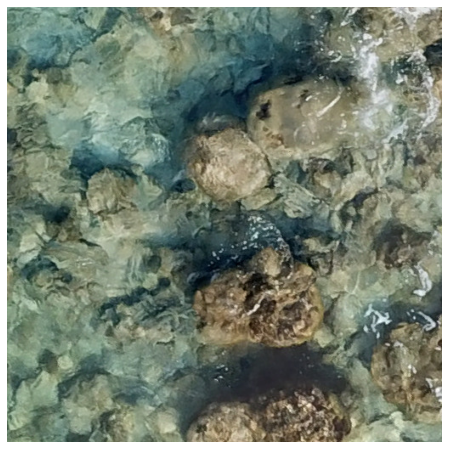

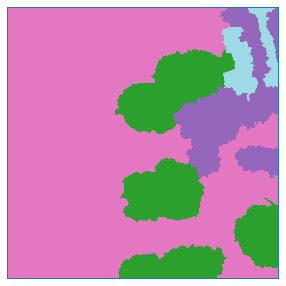

In [ ]:
r_index = random.randint(0, len(fnames)-1)
#show some data
img_f = fnames[r_index]
img = open_image(img_f)
img.show(figsize=(8,8))

#show mask
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

#sr_size=np.array(img.shape[1:])
#img.data

In [ ]:
src_size = np.array(mask.shape[1:])
print(mask)
src_size,mask.data

print('Size: {}'.format(src_size))
t = mask.data
a = t.reshape(1, -1).squeeze()
n = to_np(a)
u = []
for i in n:
  if i not in u:
    u.append(i)
print(sorted(u))
len(u)

ImageSegment (1, 512, 512)
Size: [512 512]
[0, 1, 2, 3]


4

In [ ]:
codes = np.array(['nodata',
         'coral', 
         'rocks', 
         'rubble', 
         'shallow water/sand', 
         'waves'])

In [ ]:
bs = 2

In [ ]:
data = (SegmentationItemList.from_folder(path/'trainData')
       #.split_by_folder(train=train, valid=path/'aug/valData') #splitting data by folder (make separate validation set)
       #.split_none()                                           #do not split data
       .split_by_rand_pct(0.25)                                  #split random -> put one of these on
       .label_from_func(get_y_fn, classes=codes)
       #.transform()                 #extra random transformations on 10% of the dataset
       .databunch(bs=bs).normalize())
       #.normalize())                                            #can be normalized on imagenetstats

In [ ]:
test_data = ImageList.from_folder(path/'test')
test_data
data.add_test(test_data)

In [ ]:
data

ImageDataBunch;

Train: LabelList (98 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/My Drive/Master/Data/aug/trainData;

Valid: LabelList (32 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/My Drive/Master/Data/aug/trainData;

Test: LabelList (410 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/Master/Data/aug/trainData

In [ ]:
print(data.classes)

['nodata' 'coral' 'rocks' 'rubble' 'shallow water/sand' 'waves']


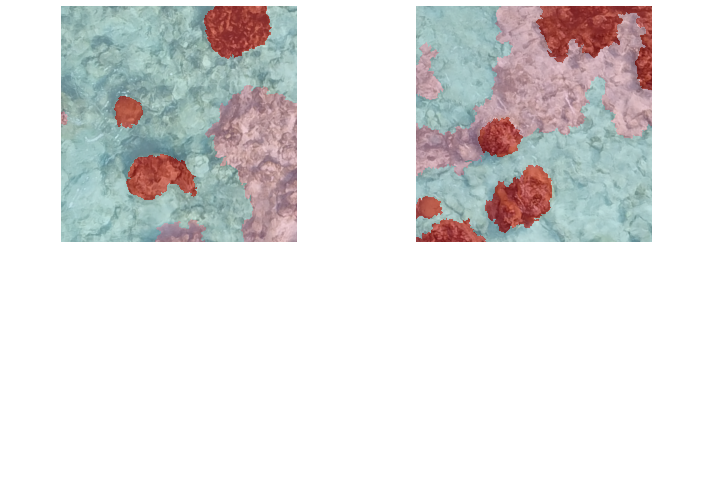

In [ ]:
data.show_batch(10, figsize=(10,7))

In [ ]:
#https://forums.fast.ai/t/create-databunch-with-multiple-segmentation-mask-as-label/53643/21
def cust_accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [ ]:
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=[cust_accuracy], 
                     wd=wd) 
                     #loss_func = nn.CrossEntropyLoss(),  #still need to add loss function instead of weight decay, for now weight decay works fine
                     #bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


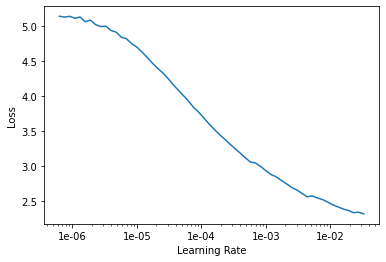

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
#chose best lr from plot
lr=2e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr))
#if this worked fine; no weird numbers and nans, tweaking can begin

epoch,train_loss,valid_loss,cust_accuracy,time
0,1.916332,1.220631,0.499340,00:18
1,1.340184,1.120234,0.514629,00:16
2,1.076538,0.868108,0.621594,00:16
3,0.937105,0.731155,0.701078,00:16
4,0.860640,0.806581,0.615379,00:16
5,0.796763,0.686863,0.726459,00:16
6,0.694544,0.620930,0.744816,00:16
7,0.599817,0.585581,0.763118,00:16
8,0.520561,0.588267,0.764416,00:16
9,0.483074,0.569494,0.769533,00:16


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/100,lr)

In [ ]:
learn.fit_one_cycle(8, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,cust_accuracy,time
0,0.463274,0.540217,0.786129,00:17
1,0.437722,0.530978,0.787098,00:17
2,0.456746,0.524565,0.794284,00:17
3,0.438246,0.582262,0.780977,00:17
4,0.443404,0.783681,0.639656,00:17
5,0.414422,0.637640,0.787233,00:17
6,0.376084,0.445943,0.829641,00:17
7,0.294190,0.448435,0.828603,00:17


In [ ]:
learn.save('stage-2');

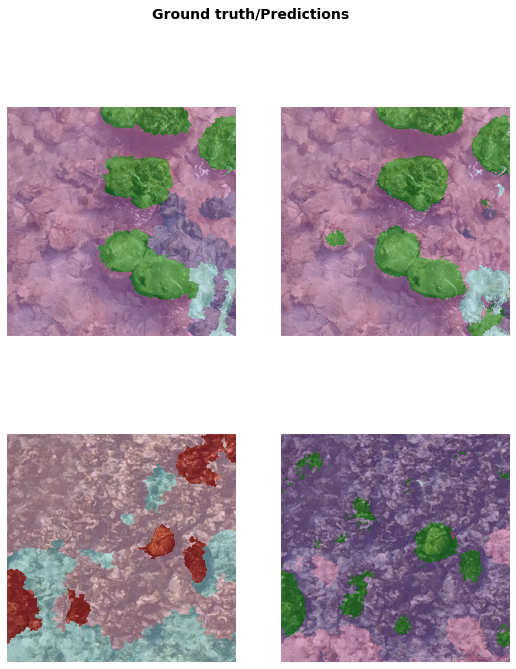

In [ ]:
learn.show_results(rows=10, figsize=(9,11))

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)

AttributeError: ignored

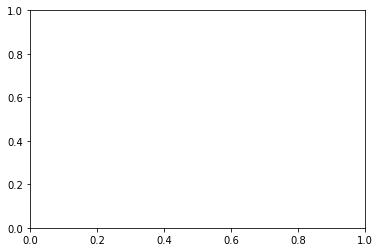

In [ ]:
#Plotting The losses for training and validation
learn.recorder.plot_losses()

In [ ]:
learn.load('stage-2');

In [ ]:
preds = learn.predict(is_test = True)

TypeError: ignored